In [44]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

LABELS = {0: "Upper part", 1: "Bottom part", 2: "One piece", 3: "Footwear", 4: "Bags"}

# Load data

In [45]:
def load_data():
    """
    Load data from pickle file
    """
    with open('../data/processed/fashion_mnist_k5.pkl', 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = load_data()

# Train with Laplace images

I have the sensation that a picture with sharper edges would be easier to classify. I will try to train the model with the Laplace images.

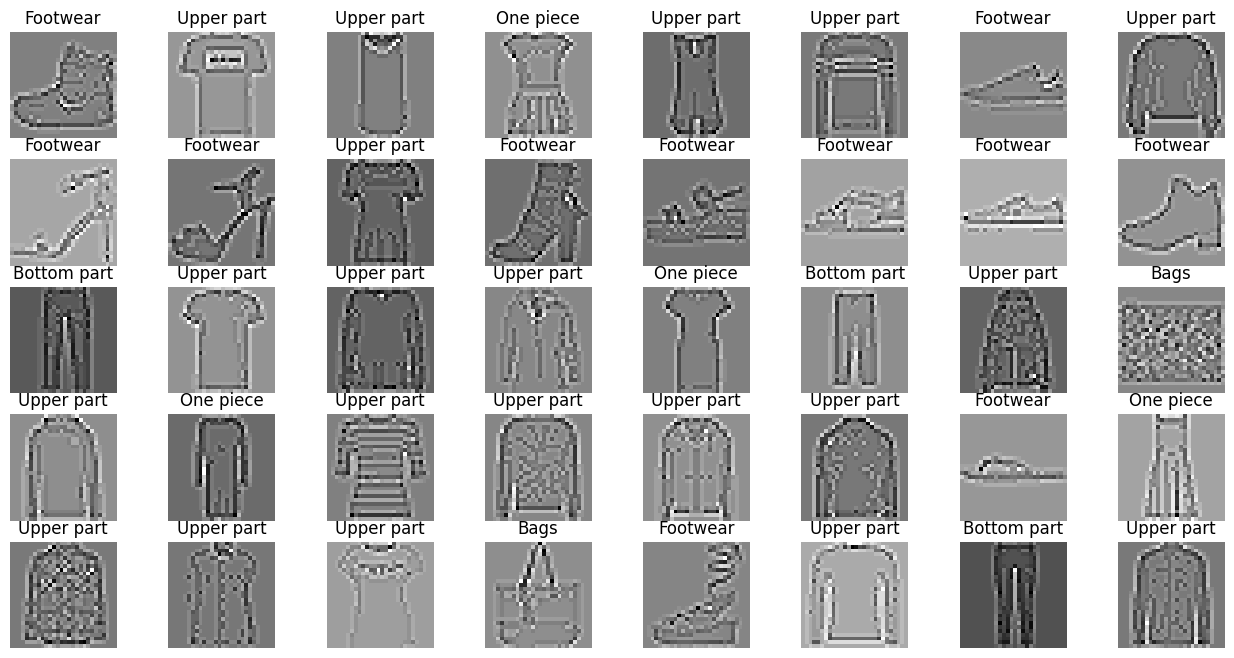

In [46]:
f, ax = plt.subplots(5,8, figsize=(16,8))

for i, image in enumerate(train_x[:40]):
    image = np.round(image / 50) * 50
    laplacian = ndimage.laplace(image)
    # Normalize between 0 and 255
    laplacian = (laplacian - laplacian.min()) / (laplacian.max() - laplacian.min()) * 255
    ax[i//8, i%8].imshow(laplacian, cmap='gray')
    ax[i//8, i%8].axis('off')
    ax[i//8, i%8].set_title(LABELS[np.argmax(train_y[i])])

plt.show()

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score


def load_data(path='../data/processed/fashion_mnist_k5.pkl'):
    """
    Load data from pickle file
    """
    with open(path, 'rb') as f:
        (train_x, train_y), (test_x, test_y) = pickle.load(f)
        return train_x, train_y, test_x, test_y
        

def cast_and_normalize_images(train, test):
    """
    Convert from integers to floats and normalize to range 0-1
    """
    # Apply sobel filter
    from scipy import ndimage
    for i in range(train.shape[0]):
        img = train[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        train[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255
        

    for i in range(test.shape[0]):
        img = test[i, :, :]
        # Change all pixels to 0, 50, 100, 150, 200, 250, 255
        img = np.round(img / 50) * 50
        # Laplace filter
        img = ndimage.laplace(img)
        # Normalize between 0 and 255
        test[i, :, :] = (img - img.min()) / (img.max() - img.min()) * 255

    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    return train_norm, test_norm


def get_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    # model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.1624 - accuracy: 0.9453 - val_loss: 0.1105 - val_accuracy: 0.9607 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0926 - accuracy: 0.9675 - val_loss: 0.1267 - val_accuracy: 0.9588 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0719 - accuracy: 0.9744 - val_loss: 0.0977 - val_accuracy: 0.9657 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0593 - accuracy: 0.9790 - val_loss: 0.0927 - val_accuracy: 0.9672 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0475 - accuracy: 0.9828 - val_loss: 0.0969 - val_accuracy: 0.9690 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0382 - accuracy: 0.9859 - val_loss: 0.0988 - val_accuracy: 0.9667 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================

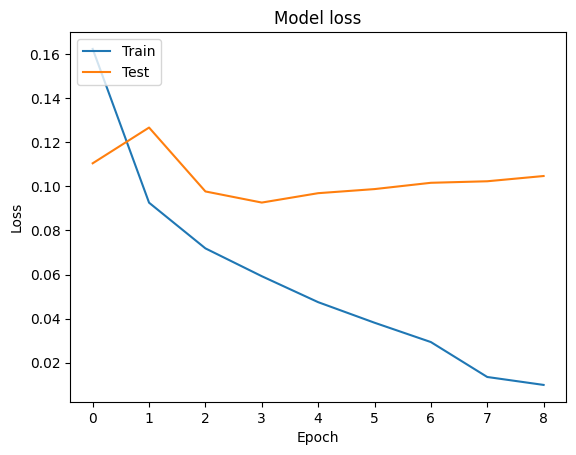

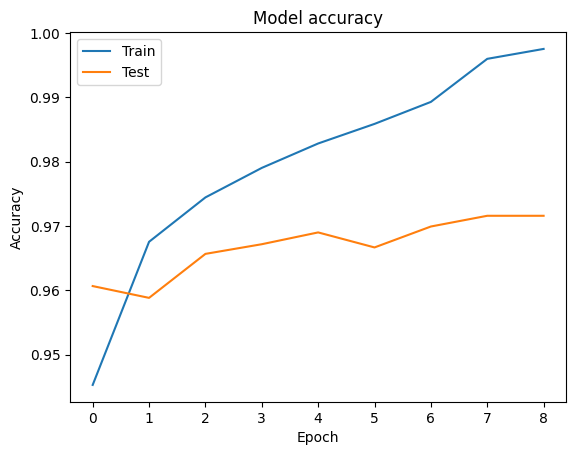

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4000
           1       0.99      0.98      0.98      1000
           2       0.89      0.88      0.89      1000
           3       1.00      1.00      1.00      3000
           4       0.97      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.97      0.97      0.97     10000

[[3883    6   88    3   20]
 [   5  977   16    0    2]
 [ 104    7  884    0    5]
 [   2    0    0 2993    5]
 [  19    1    4    9  967]]


In [48]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
model = get_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
model_loss = model.history.history['loss']
model_val_loss = model.history.history['val_loss']
plt.plot(model_loss)
plt.plot(model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/model_loss.png')
plt.show()

model_acc = model.history.history['accuracy']
model_val_acc = model.history.history['val_accuracy']
plt.plot(model_acc)
plt.plot(model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/model_acc.png')
plt.show()

# Evaluate model
y_pred = model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


At the end, the results are slightly worse than the original images.

# Bigger model

In [49]:
def get_bigger_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.2472 - accuracy: 0.9159 - val_loss: 0.1466 - val_accuracy: 0.9507 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1361 - accuracy: 0.9552 - val_loss: 0.1332 - val_accuracy: 0.9567 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1165 - accuracy: 0.9607 - val_loss: 0.1274 - val_accuracy: 0.9564 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1036 - accuracy: 0.9645 - val_loss: 0.1214 - val_accuracy: 0.9602 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.0930 - accuracy: 0.9670 - val_loss: 0.1281 - val_accuracy: 0.9597 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 18s 6ms/step - loss: 0.0851 - accuracy: 0.9697 - val_loss: 0.1303 - val_accuracy: 0.9577 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================

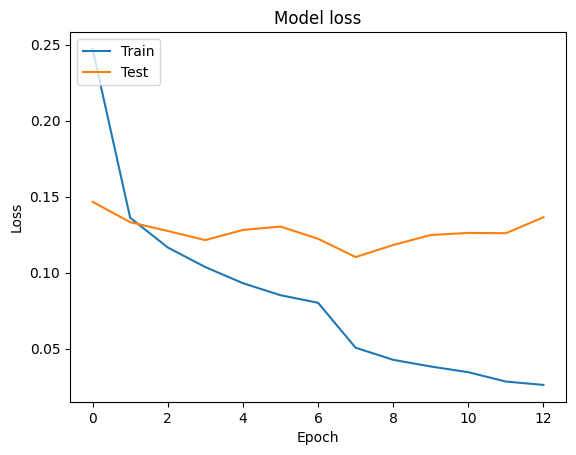

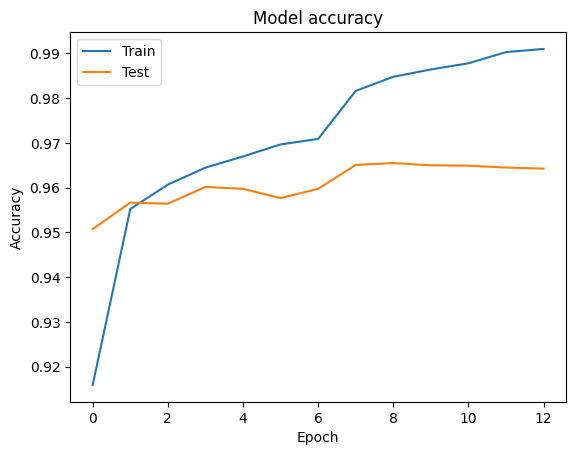

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4000
           1       0.97      0.96      0.96      1000
           2       0.90      0.83      0.87      1000
           3       1.00      1.00      1.00      3000
           4       0.96      0.96      0.96      1000

    accuracy                           0.96     10000
   macro avg       0.95      0.94      0.95     10000
weighted avg       0.96      0.96      0.96     10000

[[3880   14   76    1   29]
 [  26  958   15    0    1]
 [ 144   18  833    1    4]
 [   1    0    2 2991    6]
 [  28    1    0    8  963]]


In [50]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
big_model = get_bigger_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

big_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

# Plot loss and accuracy
big_model_loss = big_model.history.history['loss']
big_model_val_loss = big_model.history.history['val_loss']
plt.plot(big_model_loss)
plt.plot(big_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_loss.png')
plt.show()

big_model_acc = big_model.history.history['accuracy']
big_model_val_acc = big_model.history.history['val_accuracy']
plt.plot(big_model_acc)
plt.plot(big_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/big_model_acc.png')
plt.show()

# Evaluate model
y_pred = big_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


# Small model

In [51]:
def get_small_model():
    """
    Define the CNN model
    """
    model = Sequential()
    model.add(Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [52]:
train_x, train_y, test_x, test_y = load_data()
train_x, test_x = cast_and_normalize_images(train_x, test_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y,
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

# Train model
small_model = get_small_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

small_model.fit(train_x, train_y, 
          epochs=16, batch_size=16, 
          validation_data=(val_x, val_y), 
        #   class_weight={0: 0.25, 1: 1, 2: 1, 3: 0.333, 4: 1},
          callbacks=[reduce_lr, early_stop], 
          verbose=1)

Epoch 1/16
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2106 - accuracy: 0.9279 - val_loss: 0.1458 - val_accuracy: 0.9507 - lr: 0.0100
Epoch 2/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1350 - accuracy: 0.9530 - val_loss: 0.1313 - val_accuracy: 0.9532 - lr: 0.0100
Epoch 3/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1165 - accuracy: 0.9589 - val_loss: 0.1277 - val_accuracy: 0.9578 - lr: 0.0100
Epoch 4/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1027 - accuracy: 0.9641 - val_loss: 0.1344 - val_accuracy: 0.9542 - lr: 0.0100
Epoch 5/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0947 - accuracy: 0.9656 - val_loss: 0.1288 - val_accuracy: 0.9591 - lr: 0.0100
Epoch 6/16
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0853 - accuracy: 0.9697 - val_loss: 0.1337 - val_accuracy: 0.9548 - lr: 0.0100
Epoch 7/16
3000/3000 [==============================] - 9

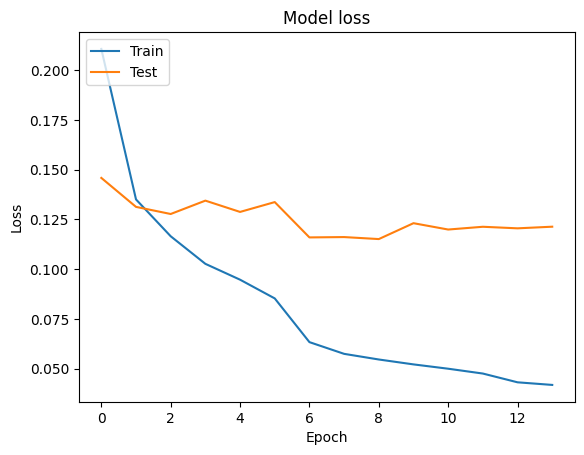

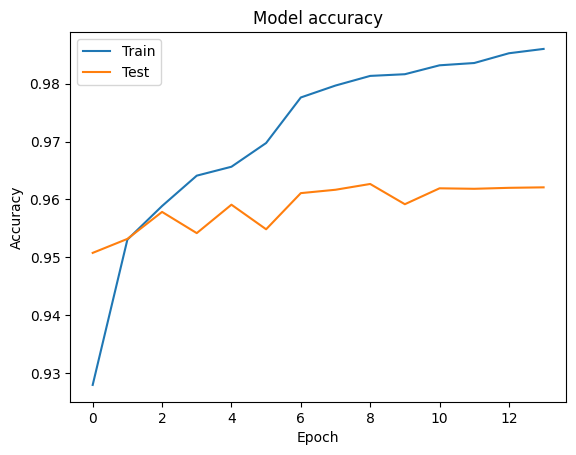

In [53]:
# Plot loss and accuracy
small_model_loss = small_model.history.history['loss']
small_model_val_loss = small_model.history.history['val_loss']
plt.plot(small_model_loss)
plt.plot(small_model_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/small_model_loss.png')
plt.show()

small_model_acc = small_model.history.history['accuracy']
small_model_val_acc = small_model.history.history['val_accuracy']
plt.plot(small_model_acc)
plt.plot(small_model_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('../plots/small_model_acc.png')
plt.show()

In [54]:

# Evaluate model
y_pred = small_model.predict(test_x)
print(classification_report(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))
print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1)))


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4000
           1       0.99      0.95      0.97      1000
           2       0.88      0.83      0.86      1000
           3       1.00      1.00      1.00      3000
           4       0.97      0.96      0.96      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.94      0.95     10000
weighted avg       0.96      0.96      0.96     10000

[[3891    1   81    3   24]
 [  16  951   31    0    2]
 [ 154    8  832    1    5]
 [   2    0    0 2996    2]
 [  35    0    1    8  956]]


# 3 plots

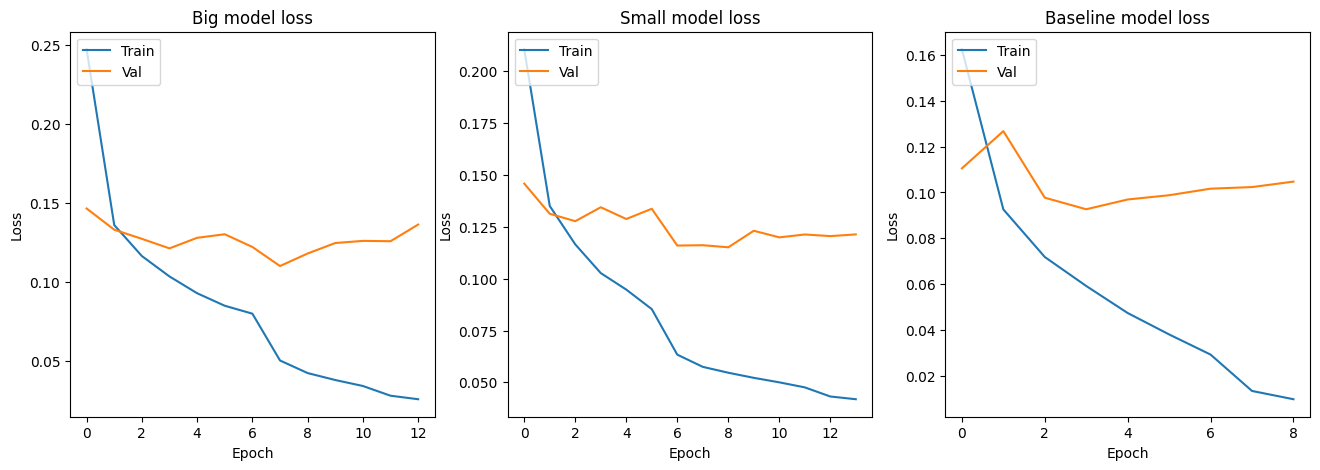

313/313 [==============================] - 1s 2ms/step


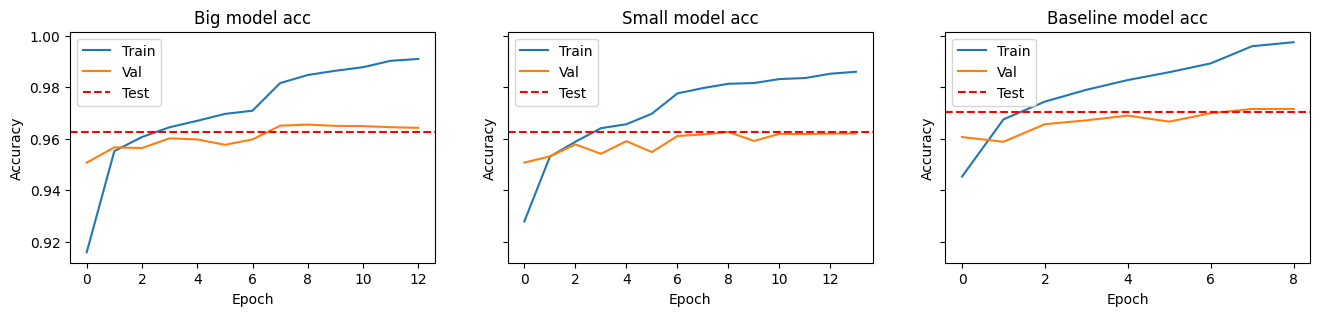

In [55]:
# Plot loss 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].plot(big_model_loss)
axs[0].plot(big_model_val_loss)
axs[0].set_title('Big model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[1].plot(small_model_loss)
axs[1].plot(small_model_val_loss)
axs[1].set_title('Small model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')
axs[2].plot(model_loss)
axs[2].plot(model_val_loss)
axs[2].set_title('Baseline model loss')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Val'], loc='upper left')

plt.savefig('../plots/loss_3_cnn.png')
plt.show()

# Plot acc 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 3), sharey=True)

axs[0].plot(big_model_acc)
axs[0].plot(big_model_val_acc)
axs[0].set_title('Big model acc')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
y_pred = big_model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[0].axhline(y=test_acc, color='r', linestyle='--')
axs[0].legend(['Train', 'Val', 'Test'], loc='upper left')

axs[1].plot(small_model_acc)
axs[1].plot(small_model_val_acc)
axs[1].set_title('Small model acc')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
y_pred = small_model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[1].axhline(y=test_acc, color='r', linestyle='--')
axs[1].legend(['Train', 'Val', 'Test'], loc='upper left')

axs[2].plot(model_acc)
axs[2].plot(model_val_acc)
axs[2].set_title('Baseline model acc')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
y_pred = model.predict(test_x)
test_acc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(y_pred, axis=1))
axs[2].axhline(y=test_acc, color='r', linestyle='--')
axs[2].legend(['Train', 'Val', 'Test'], loc='upper left')


plt.savefig('../plots/accuracy_3_cnn.png')
plt.show()